In [1]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd

from plotting import plot_utils
from model_fitting import initialize_fitting 
from utils import numpy_utils, default_paths, prf_utils
from analyze_features import analyze_feature_decoding


In [2]:
# Load everything

subject=998;
# subject=999; # 999 is our independent set of 10,000 COCO images
feature_type='gabor_solo'
which_prf_grid=5

path_to_load = default_paths.gabor_texture_feat_path
path_to_load = os.path.join(path_to_load, 'feature_decoding')
    
fn1 = os.path.join(path_to_load, 'S%d_%s_LDA_categ_all_grid%d_matchprfs.npy'%(subject, feature_type, which_prf_grid))
print(fn1)
decoding = np.load(fn1,allow_pickle=True).item()
    
names = [n.split('categ_')[1] for n in decoding['discrim_type_list']]
acc = decoding['acc']
dprime = decoding['dprime']

n_axes = len(names)

prfs_use = acc[:,0]!=0
assert(np.all(prfs_use==prf_utils.get_prfs_use_decoding()))

/user_data/mmhender/features/gabor_texture/feature_decoding/S998_gabor_solo_LDA_categ_all_grid5_matchprfs.npy


In [4]:
names

['face',
 'building',
 'animate',
 'inanimate',
 'small',
 'large',
 'indoor',
 'outdoor']

In [5]:
n = decoding['n_trials_eachlabel'][prfs_use]
np.unique(n)

array([2070])

In [11]:
assert(which_prf_grid==5)
models = prf_utils.get_prf_models(which_grid=which_prf_grid)
n_prfs = len(models)

x = models[:,0]*8.4; y = models[:,1]*8.4;
ecc = np.round(np.sqrt(models[:,0]**2+models[:,1]**2)*8.4, 4)
sizes = np.round(models[:,2]*8.4, 4)
angles = np.round(np.mod(np.arctan2(y,x)*180/np.pi, 360),1)

ecc_vals = np.unique(ecc)
size_vals = np.unique(sizes)
n_ecc = len(ecc_vals);
n_sizes = len(size_vals)
n_angles = len(np.unique(angles))

sizes_use = [size_vals[5]]
sizes_use

[1.4763]

In [31]:
import scipy
pars = [sizes, ecc, y, x]
n_pars = len(pars)
par_names = ['size', 'eccen','ypos', 'xpos']

n_iter = 10000
slope_values = np.zeros((n_axes, n_pars), dtype=float)
slope_values_shuffle = np.zeros((n_axes, n_pars, n_iter), dtype=float)

inter_values = np.zeros((n_axes, n_pars), dtype=float)
r_values = np.zeros((n_axes, n_pars), dtype=float)
p_values_parametric = np.zeros((n_axes,n_pars), dtype=float)

rndseed = 234325
np.random.seed(rndseed)

for ai in range(n_axes):

    for pi, par in enumerate(pars):
        
        print('%s, %s'%(names[ai], par_names[pi]))

        if pi==0:
            prf_inds = prfs_use
        else:
            prf_inds = (prfs_use & (np.isin(sizes, sizes_use)))

        x_vals = par[prf_inds]

        vals = dprime[prf_inds,ai]

        reg_result = scipy.stats.linregress(x_vals, vals)

        slope_values[ai,pi] = reg_result.slope
        inter_values[ai,pi] = reg_result.intercept
        r_values[ai,pi] = reg_result.rvalue
        p_values_parametric[ai,pi] = reg_result.pvalue

        # permutation test to get a non-parametric p-value
        for xx in range(n_iter):

            shuff_order = np.random.permutation(np.arange(len(x_vals)))
            shuff_x_vals = x_vals[shuff_order]
            reg_result = scipy.stats.linregress(shuff_x_vals, vals)
            slope_values_shuffle[ai,pi,xx] = reg_result.slope

face, size
face, eccen
face, ypos
face, xpos
building, size
building, eccen
building, ypos
building, xpos
animate, size
animate, eccen
animate, ypos
animate, xpos
inanimate, size
inanimate, eccen
inanimate, ypos
inanimate, xpos
small, size
small, eccen
small, ypos
small, xpos
large, size
large, eccen
large, ypos
large, xpos
indoor, size
indoor, eccen
indoor, ypos
indoor, xpos
outdoor, size
outdoor, eccen
outdoor, ypos
outdoor, xpos


In [49]:
import statsmodels
from utils import stats_utils

# compute a two-tailed p-value here:
p_values = np.minimum(np.mean(slope_values_shuffle<=slope_values[:,:,np.newaxis], axis=2), \
                      np.mean(slope_values_shuffle>=slope_values[:,:,np.newaxis], axis=2))*2

# FDR correction
mask_fdr, pvals_fdr = \
    stats_utils.fdr_keepshape(p_values, alpha=0.01)

mask_fdr_parametric, pvals_fdr_parametric = \
    stats_utils.fdr_keepshape(p_values_parametric, alpha=0.01)

mask_fdr_corrcoef, pvals_fdr_corrcoef = \
    stats_utils.fdr_keepshape(pval_corrcoef, alpha=0.01)

print(np.all(mask_fdr==mask_fdr_parametric), np.all(mask_fdr==mask_fdr_corrcoef))

mask_fdr, mask_fdr_parametric, mask_fdr_corrcoef


True True


(array([[ True,  True,  True, False],
        [False, False,  True, False],
        [ True,  True, False, False],
        [ True, False,  True, False],
        [ True,  True,  True, False],
        [False,  True, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False]]),
 array([[ True,  True,  True, False],
        [False, False,  True, False],
        [ True,  True, False, False],
        [ True, False,  True, False],
        [ True,  True,  True, False],
        [False,  True, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False]]),
 array([[ True,  True,  True, False],
        [False, False,  True, False],
        [ True,  True, False, False],
        [ True, False,  True, False],
        [ True,  True,  True, False],
        [False,  True, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False]]))

In [50]:
slopes_table = pd.DataFrame({}, index=names)
for pi in range(n_pars):
    # slopes_table['%s slope'%par_names[pi]] = slope_values[:,pi]
    # slopes_table['%s intercept'%par_names[pi]] = inter_values[:,pi]
    # slopes_table['%s corr'%par_names[pi]] = r_values[:,pi]
    slopes_table['%s pval1'%par_names[pi]] = p_values[:,pi]
    slopes_table['%s pval2'%par_names[pi]] = p_values_parametric[:,pi]
    slopes_table['%s pval3'%par_names[pi]] = pval_corrcoef[:,pi]

slopes_table.round(3)

,pRF size (deg) pval1,pRF size (deg) pval2,pRF size (deg) pval3,pRF eccen (deg) pval1,pRF eccen (deg) pval2,pRF eccen (deg) pval3,y pos (down-up) pval1,y pos (down-up) pval2,y pos (down-up) pval3,x pos (left-right) pval1,x pos (left-right) pval2,x pos (left-right) pval3
face,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.325,0.333,0.335
building,0.791,0.787,0.834,0.467,0.495,0.578,0.000,0.000,0.000,0.079,0.087,0.081
animate,0.000,0.000,0.000,0.000,0.000,0.000,0.387,0.383,0.385,0.957,0.975,0.973
inanimate,0.000,0.000,0.000,0.017,0.018,0.017,0.000,0.000,0.000,0.503,0.497,0.502
small,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.271,0.272,0.267
large,0.099,0.101,0.104,0.001,0.000,0.000,0.598,0.596,0.615,0.856,0.866,0.855
indoor,0.000,0.000,0.000,0.000,0.000,0.000,0.218,0.214,0.300,0.802,0.806,0.851
outdoor,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.783,0.796,0.791


In [14]:
# make a summary table

slopes_table = pd.DataFrame({}, index=names)
for pi in range(n_pars):
    slopes_table['%s slope'%par_names[pi]] = slope_values[:,pi]
    slopes_table['%s intercept'%par_names[pi]] = inter_values[:,pi]
    slopes_table['%s corr'%par_names[pi]] = r_values[:,pi]
    slopes_table['%s pval'%par_names[pi]] = pvals_fdr[:,pi]
    slopes_table['%s fdr sig'%par_names[pi]] = mask_fdr[:,pi]


In [51]:
slopes_table = pd.DataFrame({}, index=names)
for pi in range(n_pars):
    slopes_table['%s slope'%par_names[pi]] = slope_values[:,pi]
    # slopes_table['%s intercept'%par_names[pi]] = inter_values[:,pi]
    # slopes_table['%s corr'%par_names[pi]] = r_values[:,pi]
    # slopes_table['%s pval'%par_names[pi]] = pvals_fdr[:,pi]
    slopes_table['%s fdr sig'%par_names[pi]] = mask_fdr[:,pi]

slopes_table

,pRF size (deg) slope,pRF size (deg) fdr sig,pRF eccen (deg) slope,pRF eccen (deg) fdr sig,y pos (down-up) slope,y pos (down-up) fdr sig,x pos (left-right) slope,x pos (left-right) fdr sig
face,-0.008528,True,-0.014315,True,-0.015424,True,-0.003398,False
building,-0.000205,False,0.003031,False,-0.035709,True,-0.006969,False
animate,-0.005162,True,-0.026281,True,0.003363,False,0.000119,False
inanimate,0.032847,True,-0.013457,False,-0.045953,True,-0.003593,False
small,0.021120,True,-0.023136,True,-0.024495,True,-0.004370,False
large,-0.001174,False,-0.011937,True,-0.001670,False,0.000531,False
indoor,0.032193,True,0.028885,True,-0.004971,False,-0.000984,False
outdoor,0.034916,True,0.026697,True,-0.012900,True,-0.000978,False


In [7]:
colors = np.concatenate([np.flipud(cm.Purples(np.linspace(0,1,5)))[1:3,:], \
                        np.flipud(cm.Reds(np.linspace(0,1,5)))[1:3,:], \
                        np.flipud(cm.Blues(np.linspace(0,1,5)))[1:3,:], \
                        np.flipud(cm.Greens(np.linspace(0,1,5)))[1:3,:]])

In [25]:
n_par_types = 4;
par_names = ['pRF size (deg)', 'pRF eccen (deg)', 'y pos (down-up)', 'x pos (left-right)']

corr_each_par = np.zeros((n_axes,n_par_types))
pval_corrcoef = np.zeros((n_axes,n_par_types))

for ai in np.arange(n_axes):

    for par_ind, par in enumerate([sizes, ecc, y, x]):

        if par_ind==0:
            prf_inds = prfs_use
        else:
            prf_inds = (prfs_use & (np.isin(sizes, sizes_use)))

        x_vals = par[prf_inds]
        vals = acc[prf_inds,ai]

        rho, p = scipy.stats.pearsonr(x_vals, vals)
        
        corr_each_par[ai,par_ind] = rho
        pval_corrcoef[ai,par_ind] = p

In [83]:
pd.DataFrame(corr_each_par, index=names, columns=par_names)

,pRF size (deg),pRF eccen (deg),y pos (down-up),x pos (left-right)
face,-0.364564,-0.336614,-0.391664,-0.085885
building,0.008286,0.049679,-0.770644,-0.154589
animate,-0.246407,-0.561767,0.077412,0.002998
inanimate,0.641469,-0.210118,-0.775327,-0.059892
small,0.606498,-0.475591,-0.553611,-0.098804
large,-0.064237,-0.313197,-0.044835,0.016301
indoor,0.714611,0.595163,-0.092385,-0.016728
outdoor,0.727780,0.588003,-0.288762,-0.023673


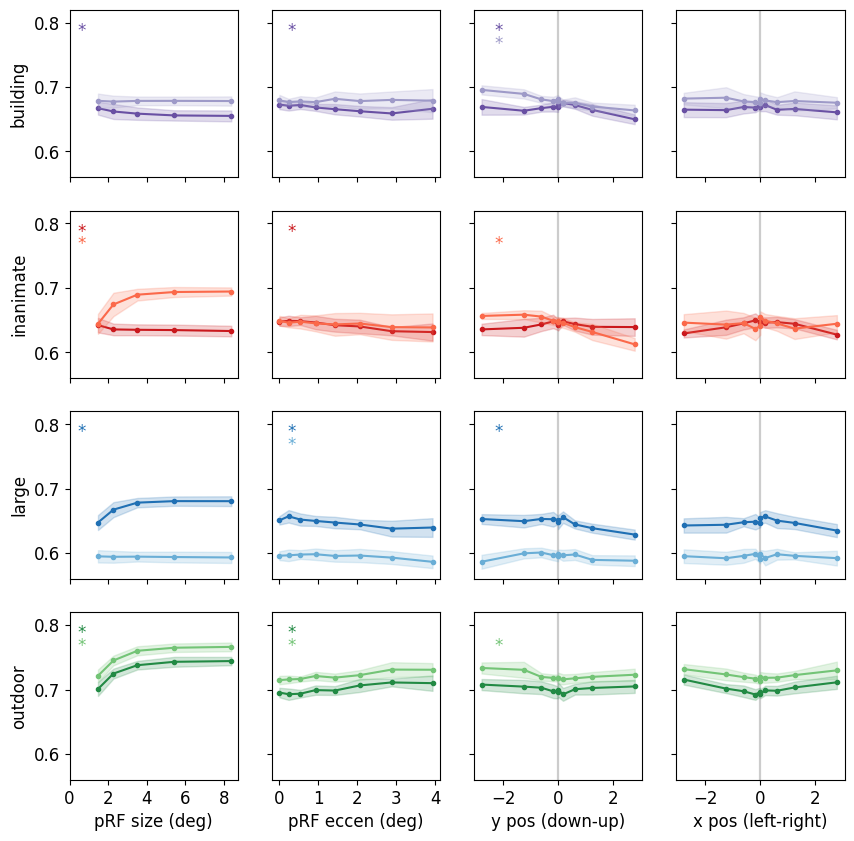

In [63]:
import scipy

sizes_use = [size_vals[5]]

plt.figure(figsize=(10,10));
plot_utils.set_all_font_sizes(12)
plt.rcParams['pdf.fonttype']=42

axes_plot = np.arange(8)

plot_inds = [(np.arange(4)+ii).astype(int) for ii in [1,1,5,5,9,9,13,13]]
plot_inds = np.array(plot_inds).ravel()

# npx = len(axes_plot)
npx = 4;

n_bins=10
linear_bins=False

# ylims = [0.48, 0.82];
ylims = [0.56, 0.82]
annot_ylocs = [0.76, 0.78]

yticks = [0.5, 0.6, 0.7, 0.8]

xticks = [[0,2,4,6,8], [0,1,2,3,4], [-2, 0, 2], [-2, 0, 2]]

par_names = ['pRF size (deg)', 'pRF eccen (deg)', 'y pos (down-up)', 'x pos (left-right)']

annot_xlocs = [0.4,0.2,-2.3,-2.3]
    
pi=0;

for ai in axes_plot:

    name = names[ai]

    for par_ind, par in enumerate(pars):

        pi+=1
        plt.subplot(npx,4,plot_inds[pi-1])

        if par_ind==0:
            prf_inds = prfs_use
        else:
            prf_inds = (prfs_use & (np.isin(sizes, sizes_use)))

        x_vals = par[prf_inds]
        vals = acc[prf_inds,ai]

        # plt.plot(x_vals, vals, '.', color=[0.8, 0.8, 0.8, 1])
        if par_ind>1:
            xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True)  
        else:
            xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                                linear_bins=linear_bins, return_std=True, \
                                                                use_unique=True)    
        plt.plot(xbinned, ybinned, '.-',color=colors[ai,:] ,zorder=10)
        plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
                alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

        if ai>5:
            plt.xlabel(par_names[par_ind])
            plt.xticks(xticks[par_ind])
        else:
            plt.xticks(xticks[par_ind], labels=[])
        if par_ind==0:
            plt.ylabel(name)
            plt.yticks(yticks)
        else:
            plt.yticks(yticks,[])
        plt.ylim(ylims)

        # print(ai, par_ind)
        # print(mask_fdr[ai,par_ind])
        # rho, p = scipy.stats.pearsonr(x_vals, vals)
        # plt.title('rho=%.2f, p=%.4f'%(rho, p))
        if mask_fdr[ai, par_ind]:
            if np.mod(ai,2):
                annot_yloc=annot_ylocs[0]
            else:
                annot_yloc=annot_ylocs[1]
            plt.annotate('*',(annot_xlocs[par_ind],annot_yloc),color=colors[ai,:])

        if par_ind>1:
            plt.axvline(0, color=[0.8, 0.8, 0.8])

        plt.axhline(0.5, linestyle='--',color=[0.8, 0.8, 0.8, 1])


In [58]:
mask_fdr.shape

(8, 4)

In [59]:
mask_fdr

array([[ True,  True,  True, False],
       [False, False,  True, False],
       [ True,  True, False, False],
       [ True, False,  True, False],
       [ True,  True,  True, False],
       [False,  True, False, False],
       [ True,  True, False, False],
       [ True,  True,  True, False]])

In [46]:
np.array(plot_inds).ravel()

array([ 1,  2,  3,  4,  1,  2,  3,  4,  5,  6,  7,  8,  5,  6,  7,  8,  9,
       10, 11, 12,  9, 10, 11, 12, 13, 14, 15, 16, 13, 14, 15, 16])

In [41]:
plot_inds

[array([1, 2, 3, 4]),
 array([1, 2, 3, 4]),
 array([5, 6, 7, 8]),
 array([5, 6, 7, 8]),
 array([ 9, 10, 11, 12]),
 array([ 9, 10, 11, 12]),
 array([13, 14, 15, 16]),
 array([13, 14, 15, 16])]

In [27]:
np.unique(sizes[prfs_use])

array([1.4763, 2.2801, 3.5215, 5.4388, 8.4   ], dtype=float32)

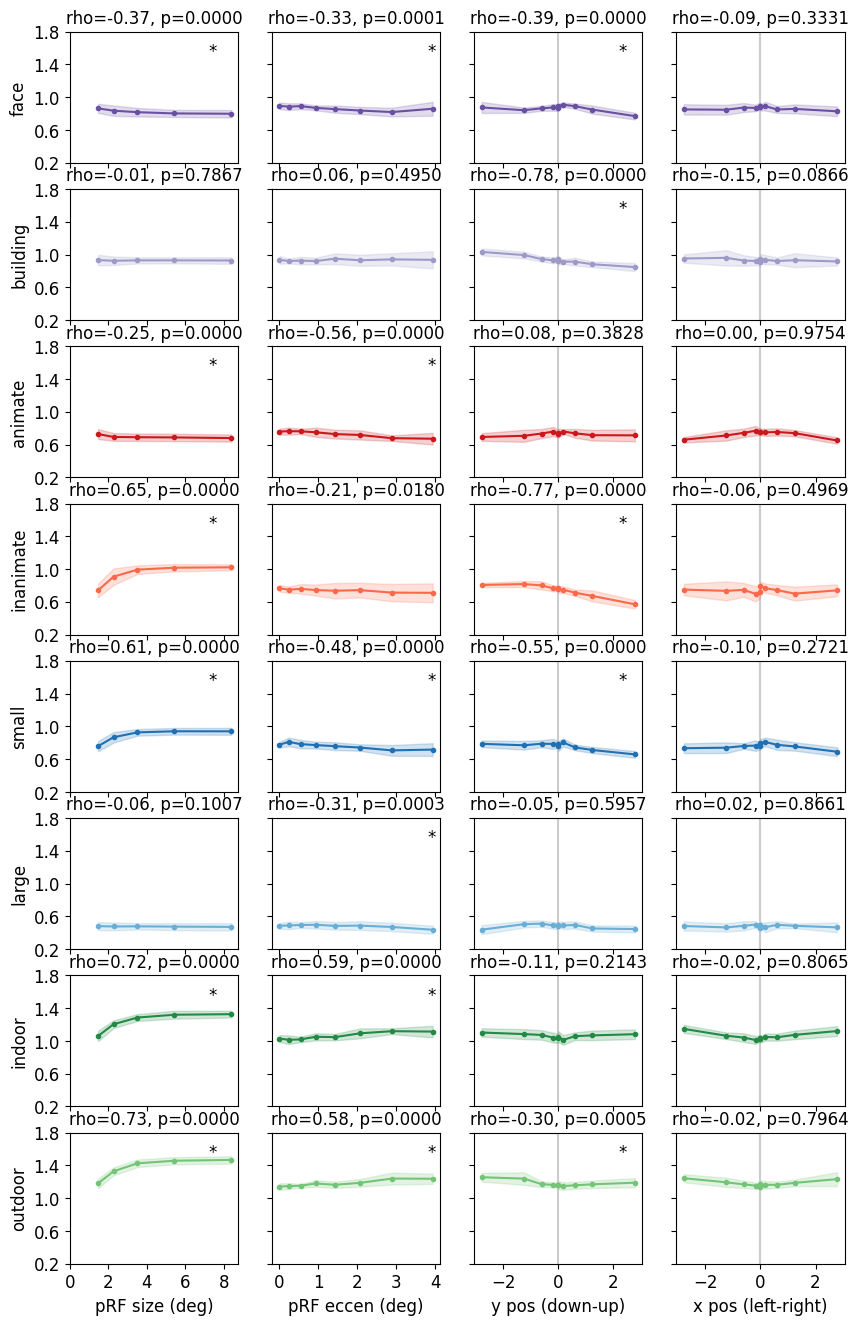

In [48]:
import scipy

plt.figure(figsize=(10,16));
plot_utils.set_all_font_sizes(12)
plt.rcParams['pdf.fonttype']=42

axes_plot = np.arange(8)

n_bins=10
linear_bins=False

ylims = [0.2, 1.8];
yticks = [0.2, 0.6, 1.0, 1.4, 1.8]

xticks = [[0,2,4,6,8], [0,1,2,3,4], [-2, 0, 2], [-2, 0, 2]]

par_names = ['pRF size (deg)', 'pRF eccen (deg)', 'y pos (down-up)', 'x pos (left-right)']

annot_locs = [7.2,3.8,2.2,2.2]

pi=0;

npx = len(axes_plot)

for ai in axes_plot:
    
    name = names[ai]
    
    for par_ind, par in enumerate([sizes, ecc, y, x]):

        pi+=1
        plt.subplot(npx,4,pi)

        if par_ind==0:
            prf_inds = prfs_use
        else:
            prf_inds = (prfs_use & (sizes==size_use))
            
        x_vals = par[prf_inds]
        vals = dprime[prf_inds,ai]

        # plt.plot(x_vals, vals, '.', color=[0.8, 0.8, 0.8, 1])
        if par_ind>1:
            xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True)  
        else:
            xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                                linear_bins=linear_bins, return_std=True, \
                                                                use_unique=True)    
        plt.plot(xbinned, ybinned, '.-',color=colors[ai,:] ,zorder=10)
        plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
                alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

        if ai==(npx-1):
            plt.xlabel(par_names[par_ind])
            plt.xticks(xticks[par_ind])
        else:
            plt.xticks(xticks[par_ind], labels=[])
        if par_ind==0:
            plt.ylabel(name)
            plt.yticks(yticks)
        else:
            plt.yticks(yticks,[])
        plt.ylim(ylims)
        
        rho, p = scipy.stats.pearsonr(x_vals, vals)
        plt.title('rho=%.2f, p=%.4f'%(rho, p))
        if p<0.01:
            plt.annotate('*',(annot_locs[par_ind],ylims[-1]-0.3))
            
        if par_ind>1:
            plt.axvline(0, color=[0.8, 0.8, 0.8])
            

In [63]:
plot_inds[pi-1]

0

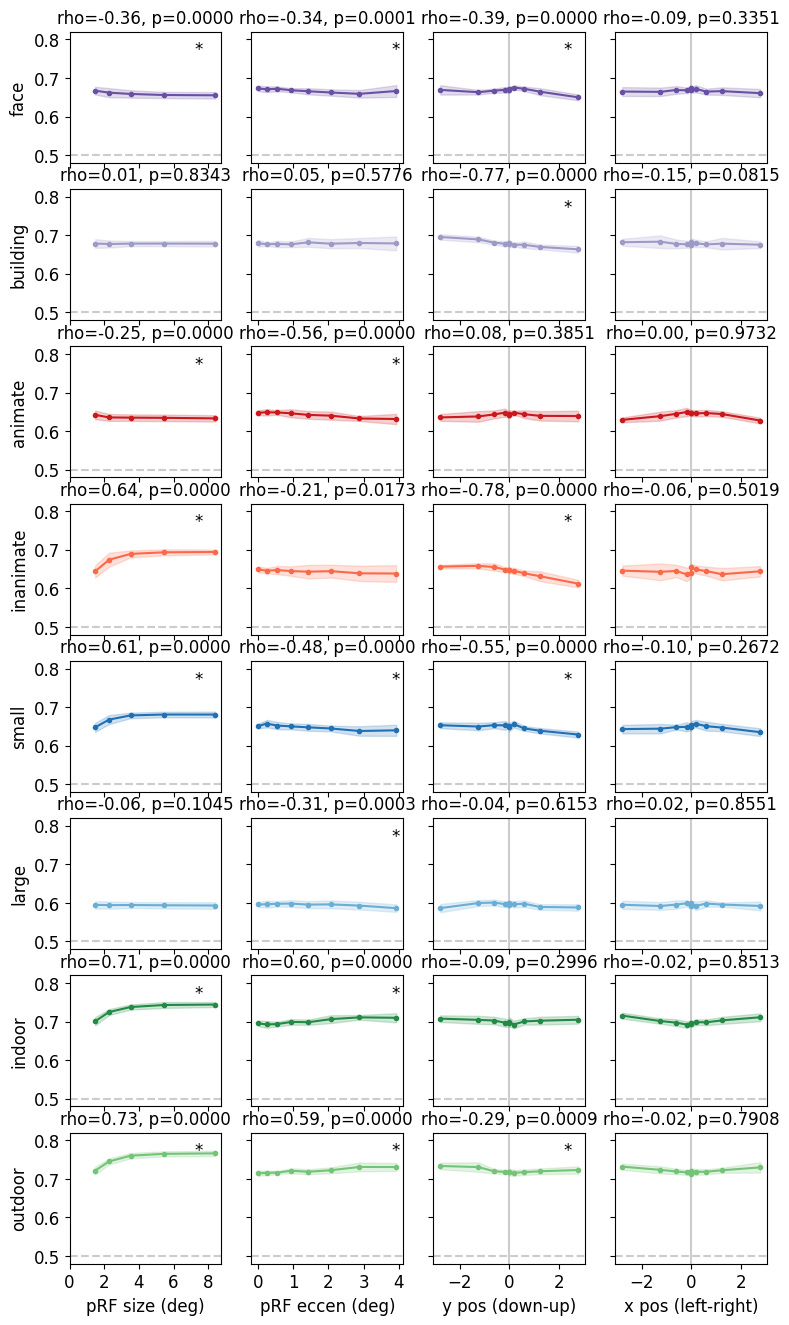

In [59]:
import scipy

sizes_use = [size_vals[5]]

plt.figure(figsize=(9,16));
plot_utils.set_all_font_sizes(12)
plt.rcParams['pdf.fonttype']=42

axes_plot = np.arange(8)

n_bins=10
linear_bins=False

ylims = [0.48, 0.82];
yticks = [0.5, 0.6, 0.7, 0.8]

xticks = [[0,2,4,6,8], [0,1,2,3,4], [-2, 0, 2], [-2, 0, 2]]

par_names = ['pRF size (deg)', 'pRF eccen (deg)', 'y pos (down-up)', 'x pos (left-right)']

annot_locs = [7.2,3.8,2.2,2.2]

pi=0;

npx = len(axes_plot)

for ai in axes_plot:

    name = names[ai]

    for par_ind, par in enumerate([sizes, ecc, y, x]):

        pi+=1
        plt.subplot(npx,4,pi)

        if par_ind==0:
            prf_inds = prfs_use
        else:
            prf_inds = (prfs_use & (np.isin(sizes, sizes_use)))

        x_vals = par[prf_inds]
        vals = acc[prf_inds,ai]

        # plt.plot(x_vals, vals, '.', color=[0.8, 0.8, 0.8, 1])
        if par_ind>1:
            xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True)  
        else:
            xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                                linear_bins=linear_bins, return_std=True, \
                                                                use_unique=True)    
        plt.plot(xbinned, ybinned, '.-',color=colors[ai,:] ,zorder=10)
        plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
                alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

        if ai==(npx-1):
            plt.xlabel(par_names[par_ind])
            plt.xticks(xticks[par_ind])
        else:
            plt.xticks(xticks[par_ind], labels=[])
        if par_ind==0:
            plt.ylabel(name)
            plt.yticks(yticks)
        else:
            plt.yticks(yticks,[])
        plt.ylim(ylims)

        rho, p = scipy.stats.pearsonr(x_vals, vals)
        plt.title('rho=%.2f, p=%.4f'%(rho, p))
        if p<0.01:
            plt.annotate('*',(annot_locs[par_ind],0.76))

        if par_ind>1:
            plt.axvline(0, color=[0.8, 0.8, 0.8])

        plt.axhline(0.5, linestyle='--',color=[0.8, 0.8, 0.8, 1])


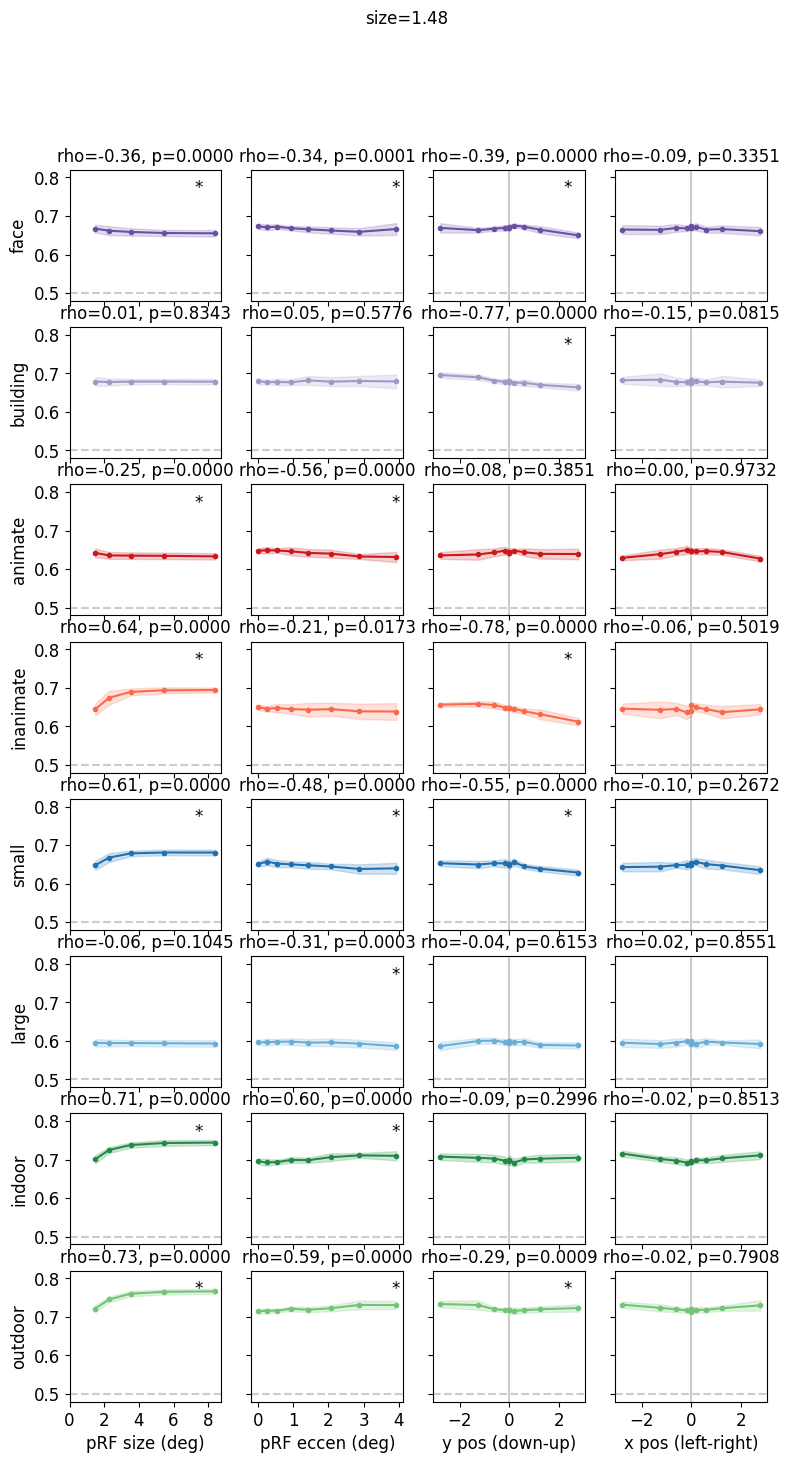

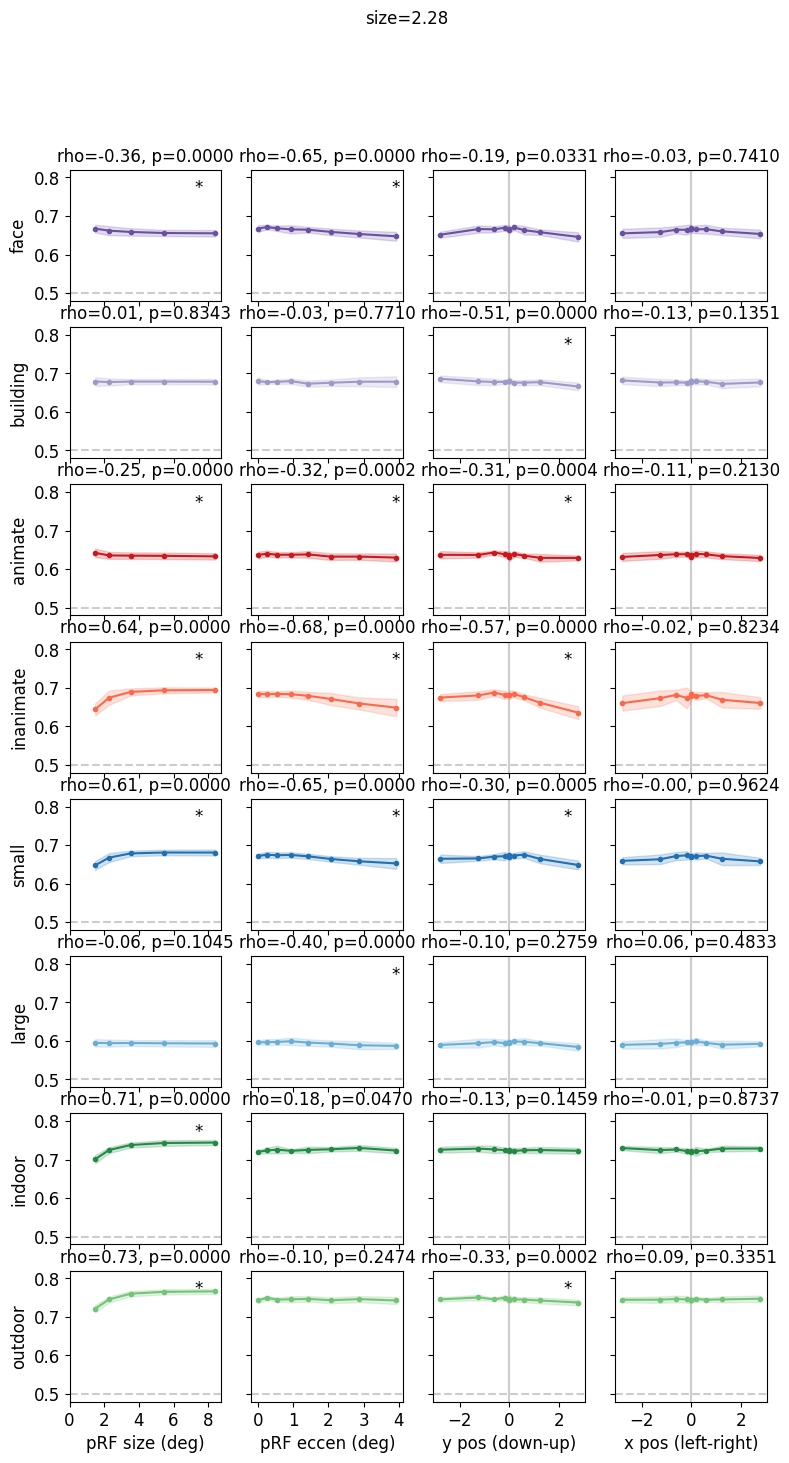

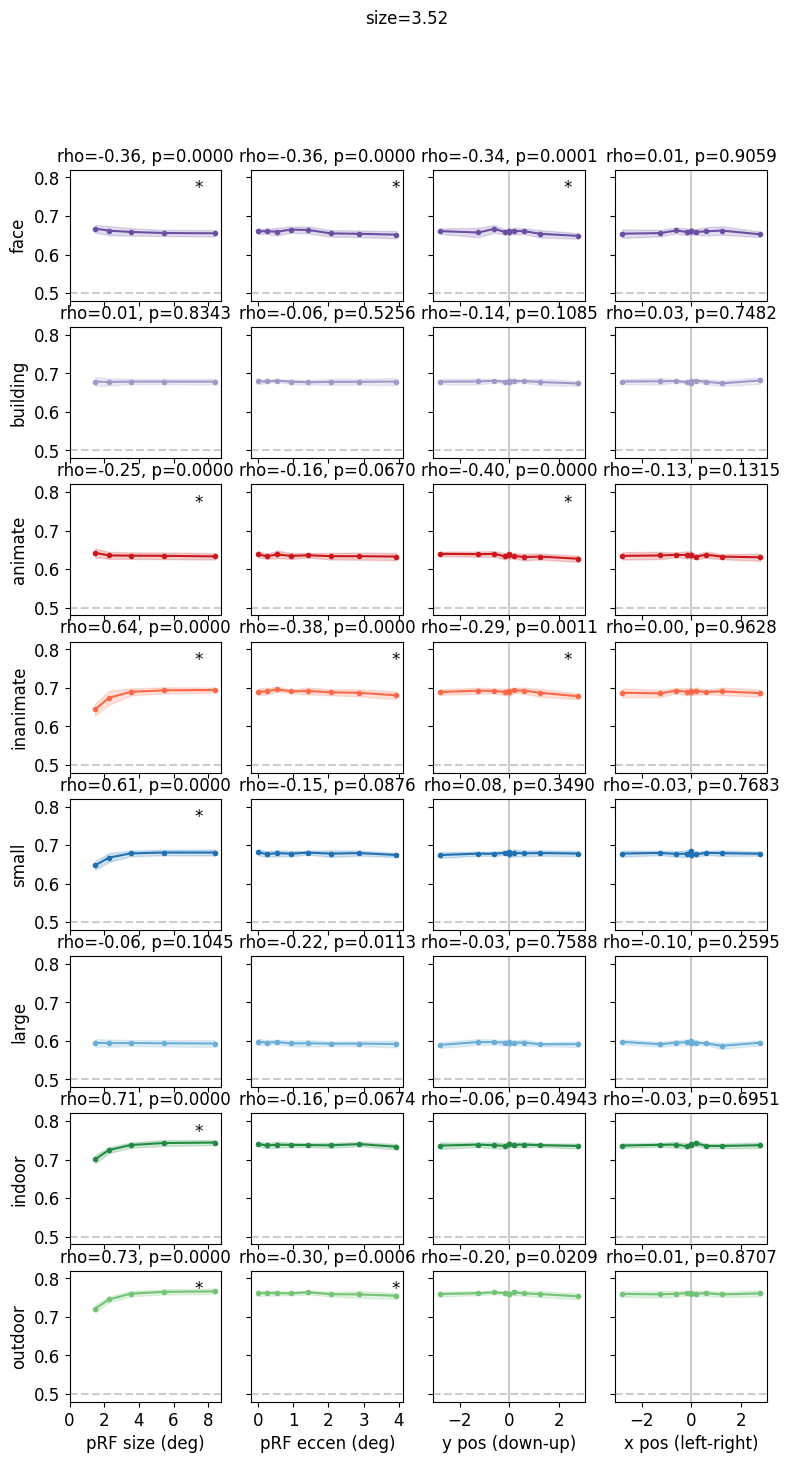

In [57]:
import scipy

for size_use in size_vals[5:8]:

    plt.figure(figsize=(9,16));
    plot_utils.set_all_font_sizes(12)
    plt.rcParams['pdf.fonttype']=42

    axes_plot = np.arange(8)

    n_bins=10
    linear_bins=False

    ylims = [0.48, 0.82];
    yticks = [0.5, 0.6, 0.7, 0.8]

    xticks = [[0,2,4,6,8], [0,1,2,3,4], [-2, 0, 2], [-2, 0, 2]]

    par_names = ['pRF size (deg)', 'pRF eccen (deg)', 'y pos (down-up)', 'x pos (left-right)']

    annot_locs = [7.2,3.8,2.2,2.2]

    pi=0;

    npx = len(axes_plot)

    for ai in axes_plot:

        name = names[ai]

        for par_ind, par in enumerate([sizes, ecc, y, x]):

            pi+=1
            plt.subplot(npx,4,pi)

            if par_ind==0:
                prf_inds = prfs_use
            else:
                prf_inds = (prfs_use & (sizes==size_use))

            x_vals = par[prf_inds]
            vals = acc[prf_inds,ai]

            # plt.plot(x_vals, vals, '.', color=[0.8, 0.8, 0.8, 1])
            if par_ind>1:
                xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                                linear_bins=linear_bins, return_std=True)  
            else:
                xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                                    linear_bins=linear_bins, return_std=True, \
                                                                    use_unique=True)    
            plt.plot(xbinned, ybinned, '.-',color=colors[ai,:] ,zorder=10)
            plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
                    alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

            if ai==(npx-1):
                plt.xlabel(par_names[par_ind])
                plt.xticks(xticks[par_ind])
            else:
                plt.xticks(xticks[par_ind], labels=[])
            if par_ind==0:
                plt.ylabel(name)
                plt.yticks(yticks)
            else:
                plt.yticks(yticks,[])
            plt.ylim(ylims)

            rho, p = scipy.stats.pearsonr(x_vals, vals)
            plt.title('rho=%.2f, p=%.4f'%(rho, p))
            if p<0.01:
                plt.annotate('*',(annot_locs[par_ind],0.76))

            if par_ind>1:
                plt.axvline(0, color=[0.8, 0.8, 0.8])

            plt.axhline(0.5, linestyle='--',color=[0.8, 0.8, 0.8, 1])

    plt.suptitle('size=%.2f'%(size_use))

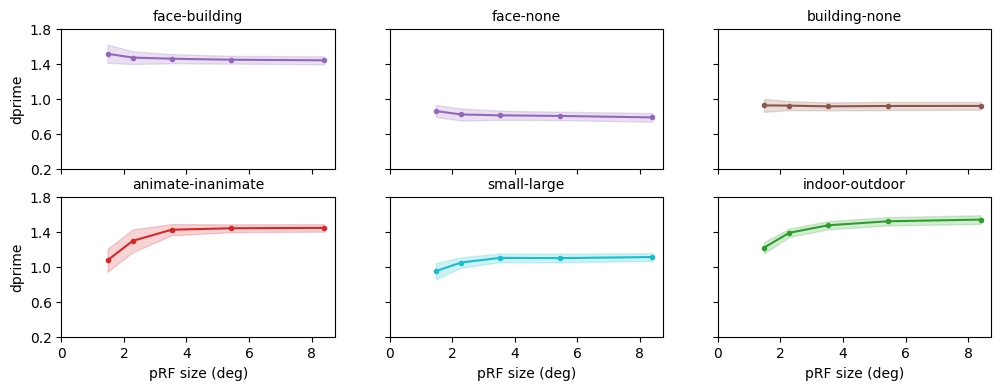

In [13]:
# plot dprime as a function of pRF params

plt.figure(figsize=(12,4));
plot_utils.set_all_font_sizes(10)
plt.rcParams['pdf.fonttype']=42

colors = cm.tab10(np.linspace(0,1,10))[[4,4,5, 3, 9,2],:]

n_bins=10
linear_bins=False

ylims = [0.2, 1.8];
yticks = [0.2, 0.6, 1.0, 1.4, 1.8]

xticks = [0,2,4,6,8]

pi=0;

for ai in range(n_axes):
    
    name = names[ai]
    vals = dprime[prfs_use,ai]
    
    pi+=1
    plt.subplot(2,3,pi)
    
    x_vals = sizes[prfs_use]

    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True, \
                                                            use_unique=True)    
    plt.plot(xbinned, ybinned, '.-',color=colors[ai,:] ,zorder=10)
    plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
            alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

    if ai>2:
        plt.xlabel('pRF size (deg)')
        plt.xticks(xticks)
    else:
        plt.xticks(xticks, labels=[])
        
    if np.mod(ai,3)==0:
        plt.ylabel('dprime')
        plt.yticks(yticks)
    else:
        plt.yticks(yticks,[])
    plt.ylim(ylims)
    
    plt.title(names[ai])
    
    

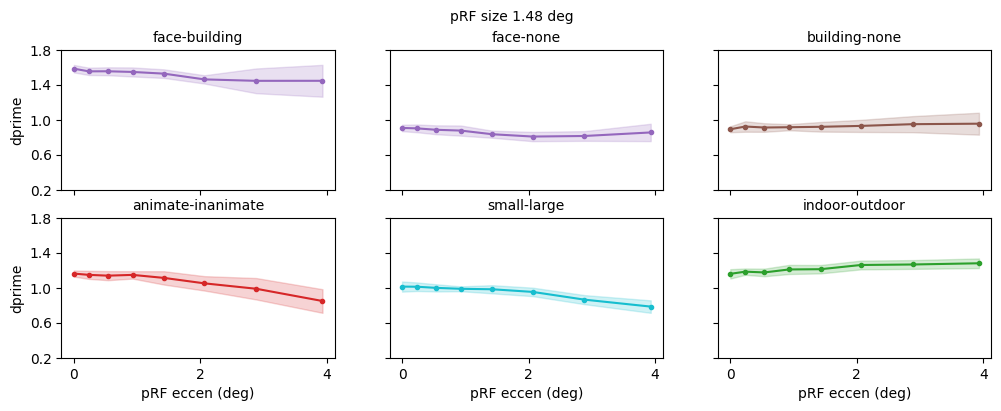

In [14]:
# plot dprime as a function of pRF params

for size_use in [size_vals[5]]:
# for size_use in np.unique(sizes[prfs_use]):

    plt.figure(figsize=(12,4));
    plot_utils.set_all_font_sizes(10)
    plt.rcParams['pdf.fonttype']=42

    colors = cm.tab10(np.linspace(0,1,10))[[4,4,5, 3, 9,2],:]

    n_bins=10
    linear_bins=False

    ylims = [0.2, 1.8];
    yticks = [0.2, 0.6, 1.0, 1.4, 1.8]

    xticks = [0,2,4]

    pi=0;

    for ai in range(n_axes):

        prf_inds = (prfs_use & (sizes==size_use))

        name = names[ai]
        vals = dprime[prf_inds,ai]

        pi+=1
        plt.subplot(2,3,pi)

        x_vals = ecc[prf_inds]

        xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                                linear_bins=linear_bins, return_std=True, \
                                                                use_unique=True)    
        plt.plot(xbinned, ybinned, '.-',color=colors[ai,:] ,zorder=10)
        plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
                alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

        if ai>2:
            plt.xlabel('pRF eccen (deg)')
            plt.xticks(xticks)
        else:
            plt.xticks(xticks, labels=[])

        if np.mod(ai,3)==0:
            plt.ylabel('dprime')
            plt.yticks(yticks)
        else:
            plt.yticks(yticks,[])
        plt.ylim(ylims)

        plt.title(names[ai])

    plt.suptitle('pRF size %.2f deg'%size_use)

Text(0.5, 0.98, 'pRF size 1.48 deg')

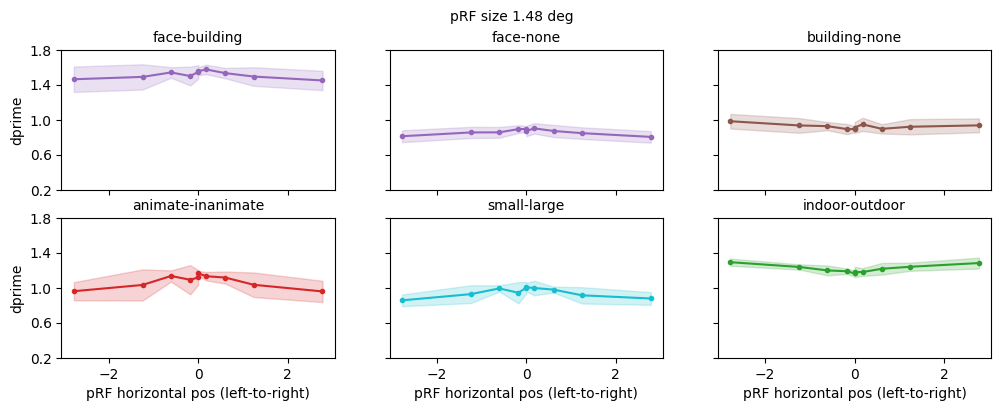

In [15]:
# plot dprime as a function of pRF params

plt.figure(figsize=(12,4));
plot_utils.set_all_font_sizes(10)
plt.rcParams['pdf.fonttype']=42

colors = cm.tab10(np.linspace(0,1,10))[[4,4, 5,3, 9,2],:]

n_bins=10
linear_bins=False

ylims = [0.2, 1.8];
yticks = [0.2, 0.6, 1.0, 1.4, 1.8]

xticks = [-2,0,2]

pi=0;

for ai in range(n_axes):
    
    prf_inds = (prfs_use & (sizes==size_use))
    
    name = names[ai]
    vals = dprime[prf_inds,ai]
    
    pi+=1
    plt.subplot(2,3,pi)
    
    x_vals = x[prf_inds]

    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True, \
                                                            use_unique=False)    
    plt.plot(xbinned, ybinned, '.-',color=colors[ai,:] ,zorder=10)
    plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
            alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

    if ai>2:
        plt.xlabel('pRF horizontal pos (left-to-right)')
        plt.xticks(xticks)
    else:
        plt.xticks(xticks, labels=[])
        
    if np.mod(ai,3)==0:
        plt.ylabel('dprime')
        plt.yticks(yticks)
    else:
        plt.yticks(yticks,[])
    plt.ylim(ylims)
    
    plt.title(names[ai])
    
plt.suptitle('pRF size %.2f deg'%size_use)

Text(0.5, 0.98, 'pRF size 1.48 deg')

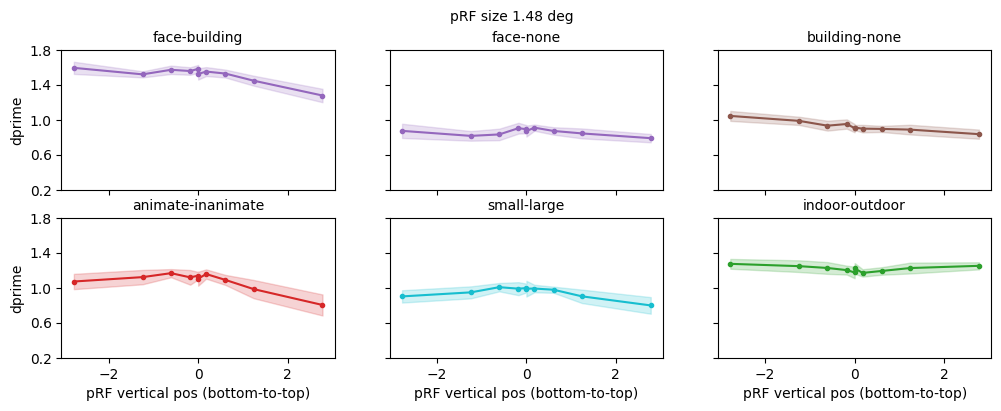

In [16]:
# plot dprime as a function of pRF params

plt.figure(figsize=(12,4));
plot_utils.set_all_font_sizes(10)
plt.rcParams['pdf.fonttype']=42

colors = cm.tab10(np.linspace(0,1,10))[[4, 4,5, 3, 9,2],:]

n_bins=10
linear_bins=False

ylims = [0.2, 1.8];
yticks = [0.2, 0.6, 1.0, 1.4, 1.8]

xticks = [-2,0,2]

pi=0;

for ai in range(n_axes):
    
    prf_inds = (prfs_use & (sizes==size_use))
    
    name = names[ai]
    vals = dprime[prf_inds,ai]
    
    pi+=1
    plt.subplot(2,3,pi)
    
    x_vals = y[prf_inds]

    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True, \
                                                            use_unique=False)    
    plt.plot(xbinned, ybinned, '.-',color=colors[ai,:] ,zorder=10)
    plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
            alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

    if ai>2:
        plt.xlabel('pRF vertical pos (bottom-to-top)')
        plt.xticks(xticks)
    else:
        plt.xticks(xticks, labels=[])
        
    if np.mod(ai,3)==0:
        plt.ylabel('dprime')
        plt.yticks(yticks)
    else:
        plt.yticks(yticks,[])
    plt.ylim(ylims)
    
    plt.title(names[ai])
    
plt.suptitle('pRF size %.2f deg'%size_use)